In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import sys
# sys.path.insert(0, '/Users/zhouji/Documents/repository2')
# import TF_Kriging.Kriging_TF_V_0_1 as KrigModel

In [3]:
def constant32(k):
    return tf.constant(k,dtype = tf.float32)

In [4]:
G_1 = constant32([[0., 1.]])

G_1_x = 1
G_1_y = 1

G_1_tiled = tf.tile(G_1,[2,1])

In [5]:
@tf.function
def squared_euclidean_distance(x_1,x_2):
    sqd = tf.sqrt(tf.reshape(tf.reduce_sum(x_1**2,1),shape =(x_1.shape[0],1))+\
    tf.reshape(tf.reduce_sum(x_2**2,1),shape =(1,x_2.shape[0]))-\
    2*tf.tensordot(x_1,tf.transpose(x_2),1))
    return sqd

In [6]:
sq =  squared_euclidean_distance(G_1_tiled,G_1_tiled)

In [7]:
sq

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.]], dtype=float32)>

In [8]:
#Cartesian distances
def cartesian_dist(x_1,x_2):
    return tf.concat([
        tf.tile(x_1[:,0] - tf.reshape(x_2[:,0],[x_2.shape[0],1]),[1,2]),
        tf.tile(x_1[:,1] - tf.reshape(x_2[:,1],[x_2.shape[0],1]),[1,2])],axis = 0) 
h_u = cartesian_dist(G_1,G_1)

In [9]:
dist_tiled = squared_euclidean_distance(G_1_tiled,G_1_tiled)

In [10]:
h_u

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.]], dtype=float32)>

In [11]:
h_v = tf.transpose(h_u)

In [12]:
a = tf.concat([tf.ones([G_1.shape[0],G_1.shape[0]]),tf.zeros([G_1.shape[0],G_1.shape[0]])],axis = 1)
b = tf.concat([tf.zeros([G_1.shape[0],G_1.shape[0]]),tf.ones([G_1.shape[0],G_1.shape[0]])],axis = 1)

perpendicularity_matrix = tf.concat([a,b],axis = 0)

In [13]:
a_T = 5
c_o_T = a_T**2/14/3

In [14]:
def cov_gradients(dist_tiled):
    C_G = (tf.math.divide_no_nan(h_u*h_v , dist_tiled**2)*\
    (-c_o_T*((-14/a_T**2)+105/4*dist_tiled/a_T**3 - 35/2 * dist_tiled**3 / a_T **5 + 21 /4 * dist_tiled**5/a_T**7)+
        c_o_T * 7 * (9 * dist_tiled ** 5 - 20 * a_T ** 2 * dist_tiled ** 3 +
                                       15 * a_T ** 4 * dist_tiled - 4 * a_T ** 5) / (2 * a_T ** 7)-
        perpendicularity_matrix * c_o_T * ((-14 / a_T ** 2) + 105 / 4 * dist_tiled / a_T ** 3 -
                                   35 / 2 * dist_tiled ** 3 / a_T ** 5 +
                                   21 / 4 * dist_tiled ** 5 / a_T ** 7))+
        1/3*tf.eye(dist_tiled.shape[0])) ## adding nugget effect
    return C_G

In [15]:
dist_tiled = dist_tiled + tf.eye(dist_tiled.shape[0])

In [16]:
C_G = cov_gradients(dist_tiled)

In [17]:
C_G

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.33333334, 0.        ],
       [0.        , 0.33333334]], dtype=float32)>

### covariance of interface points

In [18]:
#TODO : try ragged tensors to store the data
layer1 = constant32([[0,0],[2,0]])
layer2 = constant32([[0,2],[2,2]])

layer1 = constant32([[0,0],[2,0],[3,0],[4,0]])
layer2 = constant32([[0,2],[2,2],[3,3]])

number_of_layer = 2

In [19]:
layer = tf.ragged.constant([[[0,0],[2,0]],[[0,2],[2,2],[3,3]]])
layer[0].to_list()
layer[:,:1]

<tf.RaggedTensor [[[0, 0]], [[0, 2]]]>

In [20]:
number_of_points_per_surface = np.array([layer1.shape[0],layer2.shape[0]])

In [21]:
def set_rest_ref_matrix(number_of_points_per_surface):
    ref_layer_points = tf.repeat(tf.stack([layer1[-1],layer2[-1]],axis = 0),repeats=number_of_points_per_surface-1,axis = 0)
    rest_layer_points = tf.concat([layer1[0:-1],layer2[0:-1]],axis = 0)
    return ref_layer_points,rest_layer_points

In [22]:
ref_layer_points,rest_layer_points = set_rest_ref_matrix(number_of_points_per_surface)

In [23]:
sed_rest_rest = squared_euclidean_distance(rest_layer_points,rest_layer_points)
sed_ref_rest = squared_euclidean_distance(ref_layer_points,rest_layer_points)
sed_rest_ref = squared_euclidean_distance(rest_layer_points,ref_layer_points)
sed_ref_ref = squared_euclidean_distance(ref_layer_points,ref_layer_points)

In [24]:
def cov_interface(ref_layer_points,rest_layer_points):
    sed_rest_rest = squared_euclidean_distance(rest_layer_points,rest_layer_points)
    sed_ref_rest = squared_euclidean_distance(ref_layer_points,rest_layer_points)
    sed_rest_ref = squared_euclidean_distance(rest_layer_points,ref_layer_points)
    sed_ref_ref = squared_euclidean_distance(ref_layer_points,ref_layer_points)
    
    C_I = c_o_T*((1 - 7 * (sed_rest_rest / a_T) ** 2 +\
                 35 / 4 * (sed_rest_rest / a_T) ** 3 -\
                 7 / 2 * (sed_rest_rest / a_T) ** 5 +\
                 3 / 4 * (sed_rest_rest / a_T) ** 7) -\
                 (1 - 7 * (sed_ref_rest / a_T) ** 2 +\
                  35 / 4 * (sed_ref_rest / a_T) ** 3 -\
                  7 / 2 * (sed_ref_rest / a_T) ** 5 +\
                  3 / 4 * (sed_ref_rest / a_T) ** 7) -\
                 (1 - 7 * (sed_rest_ref / a_T) ** 2 +\
                  35 / 4 * (sed_rest_ref / a_T) ** 3 -\
                  7 / 2 * (sed_rest_ref / a_T) ** 5 +\
                  3 / 4 * (sed_rest_ref / a_T) ** 7) +\
                 (1 - 7 * (sed_ref_ref / a_T) ** 2 +\
                  35 / 4 * (sed_ref_ref / a_T) ** 3 -\
                  7 / 2 * (sed_ref_ref / a_T) ** 5 +\
                  3 / 4 * (sed_ref_ref / a_T) ** 7))
    
    return C_I

In [25]:
C_I = cov_interface(ref_layer_points,rest_layer_points)

In [26]:
C_I

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1.1780878 , 0.5890439 , 0.19020197, 0.29198828, 0.0512414 ],
       [0.5890439 , 0.7078704 , 0.3539352 , 0.09175344, 0.14899345],
       [0.190202  , 0.3539352 , 0.25132185, 0.0027657 , 0.08247576],
       [0.29198828, 0.09175344, 0.0027657 , 1.0835989 , 0.40705296],
       [0.0512414 , 0.14899345, 0.08247576, 0.40705296, 0.43837753]],
      dtype=float32)>

### Covariance of interface points and gradients

In [27]:
sed_dips_rest = squared_euclidean_distance(G_1_tiled,rest_layer_points)
sed_dips_ref = squared_euclidean_distance(G_1_tiled,ref_layer_points)

In [28]:
## Cartesian distance between dips and interface points
#Cartesian distances
def cartesian_dist_no_tile(x_1,x_2):
    return tf.concat([
        tf.transpose((x_1[:,0] - tf.reshape(x_2[:,0],[x_2.shape[0],1]))),
        tf.transpose((x_1[:,1] - tf.reshape(x_2[:,1],[x_2.shape[0],1])))],axis = 0) 

hu_rest = cartesian_dist_no_tile(G_1,rest_layer_points)
hu_ref = cartesian_dist_no_tile(G_1,ref_layer_points)

In [29]:
def cov_interface_gradients(hu_rest,hu_ref):
    C_GI = (hu_rest*(- c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_rest / a_T ** 3 -
                                  35 / 2 * sed_dips_rest ** 3 / a_T ** 5 +
                                  21 / 4 * sed_dips_rest ** 5 / a_T ** 7))-\
    hu_ref*(-c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_ref / a_T ** 3 -
                                  35 / 2 * sed_dips_ref ** 3 / a_T ** 5 +
                                  21 / 4 * sed_dips_ref ** 5 / a_T ** 7)))
    return C_GI

In [30]:
C_GI = cov_interface_gradients(hu_rest,hu_ref)

In [31]:
C_IG = tf.transpose(C_GI)

\begin{equation}
\left(\begin{array}{ll}
{K} & {U^{T}} \\
{U} & {0}
\end{array}\right)
\end{equation}

### Kriging Matrix

In [32]:
K = tf.concat([tf.concat([C_G,C_GI],axis = 1),
tf.concat([C_IG,C_I],axis = 1)],axis = 0)


In [33]:
import pandas as pd
pd.DataFrame(K.numpy())

,0,1,2,3,4,5,6
0,0.333333,0.000000,0.015699,-0.162014,-0.076728,0.043519,-0.134194
1,0.000000,0.333333,0.207702,0.084932,0.026884,-0.182614,-0.059844
2,0.015699,0.207702,1.178088,0.589044,0.190202,0.291988,0.051241
3,-0.162014,0.084932,0.589044,0.707870,0.353935,0.091753,0.148993
4,-0.076728,0.026884,0.190202,0.353935,0.251322,0.002766,0.082476
5,0.043519,-0.182614,0.291988,0.091753,0.002766,1.083599,0.407053
6,-0.134194,-0.059844,0.051241,0.148993,0.082476,0.407053,0.438378


In [34]:
b = tf.concat([[G_1_x,G_1_y],tf.zeros(K.shape[0]-G_1.shape[0]*2)],axis = 0)
b = tf.reshape(b,shape = [b.shape[0],1])
b

<tf.Tensor: shape=(7, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [35]:
w = tf.linalg.solve(K,b)

In [36]:
w

<tf.Tensor: shape=(7, 1), dtype=float32, numpy=
array([[ 4.5691385],
       [ 4.145193 ],
       [-2.1720994],
       [ 3.2282546],
       [-2.3534815],
       [ 0.3769913],
       [ 1.2139671]], dtype=float32)>

### Interpolation without Universal term

In [37]:
## create grid

xx = tf.range(-.5,4.5,0.1)
yy = tf.range(-.5,4.5,0.1)
XX,YY = tf.meshgrid(xx,yy)
X = tf.transpose(tf.reshape(XX,[-1]))
Y = tf.transpose(tf.reshape(YY,[-1]))

grid = tf.stack([X,Y],axis = 1)

In [38]:
hu_Simpoints = cartesian_dist_no_tile(G_1,grid)

In [39]:
sed_dips_SimPoint = squared_euclidean_distance(G_1_tiled,grid)

In [40]:
# gradient contribution
sigma_0_grad = w[:G_1.shape[0]*2] * (-hu_Simpoints*(- c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_SimPoint / a_T ** 3 -
                               35 / 2 * sed_dips_SimPoint ** 3 / a_T ** 5 +
                               21 / 4 * sed_dips_SimPoint ** 5 / a_T ** 7)))

sigma_0_grad = tf.reduce_sum(sigma_0_grad,axis=0)

In [41]:
sed_rest_SimPoint = squared_euclidean_distance(rest_layer_points,grid)
sed_ref_SimPoint = squared_euclidean_distance(ref_layer_points,grid)

In [42]:
# surface point contribution
sigma_0_interf = -w[G_1.shape[0]*2:]*(c_o_T  * ((1 - 7 * (sed_rest_SimPoint / a_T) ** 2 +
             35 / 4 * (sed_rest_SimPoint / a_T) ** 3 -
             7 / 2 * (sed_rest_SimPoint / a_T) ** 5 +
             3 / 4 * (sed_rest_SimPoint / a_T) ** 7) -
             (1 - 7 * (sed_ref_SimPoint / a_T) ** 2 +
              35 / 4 * (sed_ref_SimPoint / a_T) ** 3 -
              7 / 2 * (sed_ref_SimPoint / a_T) ** 5 +
              3 / 4 * (sed_ref_SimPoint / a_T) ** 7)))
sigma_0_interf = tf.reduce_sum(sigma_0_interf,axis = 0)

In [43]:
interpolate_result = sigma_0_grad+sigma_0_interf

In [44]:
intp = tf.reshape(interpolate_result,[50,50])

In [45]:
x1 = [0,0]
x2 = [2,0]
x_int1 = np.vstack([x1,x2])
# interface 2:
x3 = [0,2]
x4 = [2,2]
x_int2 = np.vstack([x3,x4])
# orientation point:
x5 = [0,1]
x = np.vstack([x1, x2, x3, x4, x5])
# orientation values
gx5 = 1.
gy5 = 1.

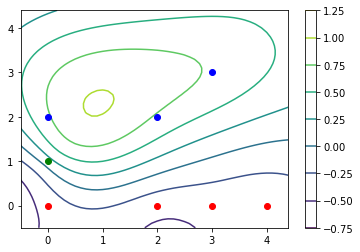

In [46]:
plt.contour(XX,YY,intp)
plt.colorbar()
plt.plot(layer1[:,0], layer1[:,1], 'ro')
plt.plot(layer2[:,0], layer2[:,1], 'bo')

plt.plot(G_1[0,0], G_1[0,1], 'go')

### add drift term

\begin{equation}
\left(\begin{array}{ll}
{K} & {U^{T}} \\
{U} & {0}
\end{array}\right)
\end{equation}

In [47]:
U = tf.concat([tf.eye(number_of_layer),
tf.stack([ref_layer_points[:,0] - rest_layer_points[:,0],
ref_layer_points[:,1] - rest_layer_points[:,1]])],axis = 1)

U_T = tf.transpose(U)


In [48]:
### new K matrix

zero_matrix = tf.zeros([2,2])

K_U = tf.concat([tf.concat([K,U_T],axis = 1),tf.concat([U,zero_matrix],axis = 1)],axis = 0)

In [49]:
pd.DataFrame(K_U.numpy())

,0,1,2,3,4,5,6,7,8
0,0.333333,0.000000,0.015699,-0.162014,-0.076728,0.043519,-0.134194,1.0,0.0
1,0.000000,0.333333,0.207702,0.084932,0.026884,-0.182614,-0.059844,0.0,1.0
2,0.015699,0.207702,1.178088,0.589044,0.190202,0.291988,0.051241,4.0,0.0
3,-0.162014,0.084932,0.589044,0.707870,0.353935,0.091753,0.148993,2.0,0.0
4,-0.076728,0.026884,0.190202,0.353935,0.251322,0.002766,0.082476,1.0,0.0
5,0.043519,-0.182614,0.291988,0.091753,0.002766,1.083599,0.407053,3.0,1.0
6,-0.134194,-0.059844,0.051241,0.148993,0.082476,0.407053,0.438378,1.0,1.0
7,1.000000,0.000000,4.000000,2.000000,1.000000,3.000000,1.000000,0.0,0.0
8,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.0


In [50]:
### universal contribution
sigma_0_1st_drift = tf.reduce_sum(grid * tf.transpose(w[-2:]),axis = 1)
sigma_0_1st_drift

<tf.Tensor: shape=(2500,), dtype=float32, numpy=
array([-0.7954792, -0.7577801, -0.7200809, ...,  6.924816 ,  6.962515 ,
        7.000214 ], dtype=float32)>

In [51]:
# rhs b-vector
b = tf.concat([[G_1_x,G_1_y],tf.zeros(K_U.shape[0]-G_1.shape[0]*2)],axis = 0)
b = tf.reshape(b,shape = [b.shape[0],1])

In [52]:
w = tf.linalg.solve(K_U,b)

In [53]:
w

<tf.Tensor: shape=(9, 1), dtype=float32, numpy=
array([[ 3.7779593 ],
       [ 0.89168227],
       [-1.4226352 ],
       [ 3.0688784 ],
       [-2.2895322 ],
       [-0.5219804 ],
       [-0.36970186],
       [ 0.05765041],
       [ 0.68171823]], dtype=float32)>

In [59]:
# gradient contribution
sigma_0_grad = w[:G_1.shape[0]*2] * (-hu_Simpoints*(- c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_SimPoint / a_T ** 3 -
                               35 / 2 * sed_dips_SimPoint ** 3 / a_T ** 5 +
                               21 / 4 * sed_dips_SimPoint ** 5 / a_T ** 7)))

sigma_0_grad = tf.reduce_sum(sigma_0_grad,axis=0)

# surface point contribution
sigma_0_interf = -w[G_1.shape[0]*2:-2]*(c_o_T  * ((1 - 7 * (sed_rest_SimPoint / a_T) ** 2 +
             35 / 4 * (sed_rest_SimPoint / a_T) ** 3 -
             7 / 2 * (sed_rest_SimPoint / a_T) ** 5 +
             3 / 4 * (sed_rest_SimPoint / a_T) ** 7) -
             (1 - 7 * (sed_ref_SimPoint / a_T) ** 2 +
              35 / 4 * (sed_ref_SimPoint / a_T) ** 3 -
              7 / 2 * (sed_ref_SimPoint / a_T) ** 5 +
              3 / 4 * (sed_ref_SimPoint / a_T) ** 7)))
sigma_0_interf = tf.reduce_sum(sigma_0_interf,axis = 0)


In [60]:
sigma_0_1st_drift = tf.reduce_sum(grid * tf.transpose(w[-2:]),axis = 1)
sigma_0_1st_drift

<tf.Tensor: shape=(2500,), dtype=float32, numpy=
array([-0.3696843 , -0.3639193 , -0.35815424, ...,  3.2416906 ,
        3.2474556 ,  3.2532206 ], dtype=float32)>

In [61]:
interpolate_result = sigma_0_grad+sigma_0_interf+sigma_0_1st_drift

intp = tf.reshape(interpolate_result,[50,50]) # reshape the result to matrix shape

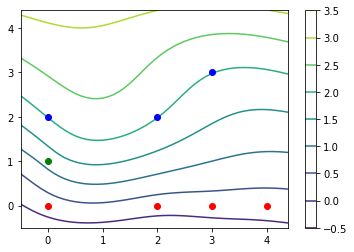

In [62]:
plt.contour(XX,YY,intp)
plt.colorbar()
plt.plot(layer1[:,0], layer1[:,1], 'ro')
plt.plot(layer2[:,0], layer2[:,1], 'bo')

plt.plot(G_1[0,0], G_1[0,1], 'go')